In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
retail = pd.read_csv('data.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
retail.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [4]:
retail.describe(include = "object").T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


The quantity has a wide range, with a minimum value of -80995 and a maximum value of 80995. The negative values indicate returned or cancelled orders, which need to be handled appropriately.
The standard deviation is quite large, indicating a significant spread in the data. The presence of outliers is indicated by a large difference between the maximum and the 75th percentile values.

The unit price also shows a wide range, from -11062.06 to 38970, which suggests the presence of errors or noise in the data, as negative prices don't make sense.
Similar to the Quantity column, the presence of outliers is indicated by a large difference between the maximum and the 75th percentile values.

The transactions come from 38 different countries, with a dominant majority of the transactions (approximately 91.4%) originating from the United Kingdom.


In [5]:
retail.dropna(subset = ["CustomerID","Description"],inplace = True)

In [6]:
duplicate_rows = retail[retail.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom


In [7]:
retail.drop_duplicates(inplace=True)
retail.shape[0]

401604

In [8]:
retail['Transaction_Status'] = np.where(retail['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')
canceled_transaction =  retail[retail['Transaction_Status']=="Cancelled"]
canceled_transaction.describe()

,Quantity,UnitPrice,CustomerID
count,8872.000000,8872.000000,8872.000000
mean,-30.774910,18.899512,14990.152953
std,1172.249902,445.190864,1708.230387
min,-80995.000000,0.010000,12346.000000
25%,-6.000000,1.450000,13505.000000
50%,-2.000000,2.950000,14868.000000
75%,-1.000000,4.950000,16393.000000
max,-1.000000,38970.000000,18282.000000


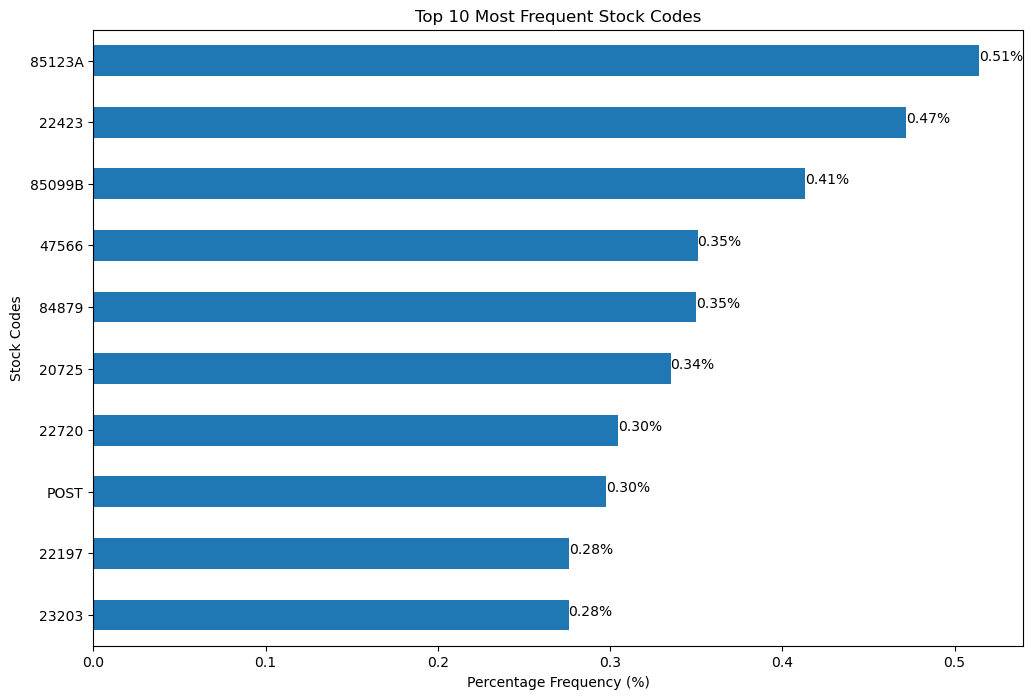

In [9]:
plt.figure(figsize=(12,8))
top_10_stock_codes = retail['StockCode'].value_counts(normalize = True).head(10)*100
top_10_stock_codes.plot(kind='barh')
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes') 
plt.gca().invert_yaxis()
plt.show()

In [10]:
count = (retail['Quantity'] <0).sum()
count

8872

In [11]:
canceled_rate = round((canceled_transaction.shape[0]/retail.shape[0])*100,2)
print(f" canceled rate is {canceled_rate} %")

 canceled rate is 2.21 %


In [12]:
unique_stock_codes = retail['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique stock codes
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
dtype: int64


In [13]:
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [14]:
percentage_anomalous = (retail['StockCode'].isin(anomalous_stock_codes).sum() / len(retail)) * 100

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.48%


In [15]:
retail = retail[~retail['StockCode'].isin(anomalous_stock_codes)]
retail.shape[0]

399689

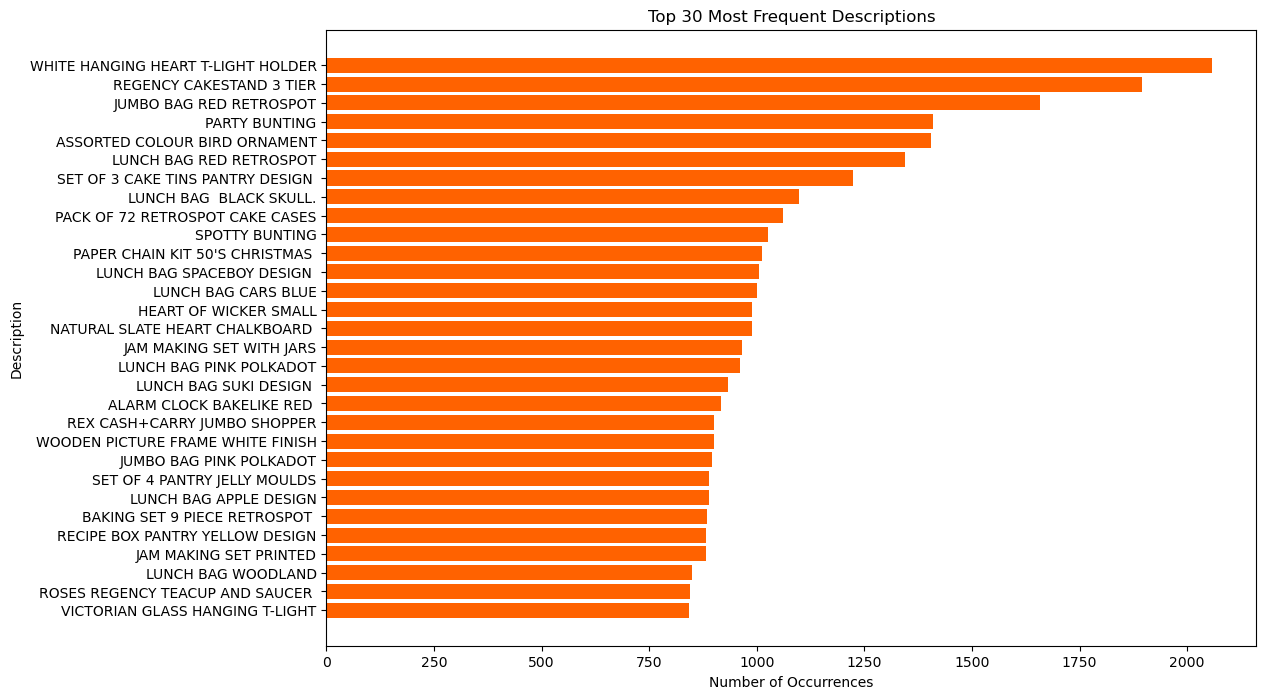

In [16]:
description_counts = retail['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

In [17]:
lowercase_descriptions = retail["Description"].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


In [18]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]
service_related_percentage =retail[retail['Description'].isin(service_related_descriptions)].shape[0] / retail.shape[0] * 100

# Print the percentage of records with service-related descriptions
print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

# Remove rows with service-related information in the description
retail = retail[~retail['Description'].isin(service_related_descriptions)]

# Standardize the text to uppercase to maintain uniformity across the dataset
retail['Description'] = retail['Description'].str.upper()

The percentage of records with service-related descriptions in the dataset is: 0.02%


In [19]:
retail['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [20]:
count = (retail['UnitPrice'] ==0).sum()
print(count)

33


In [21]:
retail = retail[retail['UnitPrice']>0]
retail.reset_index(drop=True, inplace=True)
retail.shape[0]

399573

# RFM segmentation 

In [22]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
retail['InvoiceDay'] = retail['InvoiceDate'].dt.date
rfm= retail.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = retail['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
rfm['InvoiceDay'] = pd.to_datetime(rfm['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
rfm['Days_Since_Last_Purchase'] = (most_recent_date - rfm['InvoiceDay']).dt.days

# Remove the InvoiceDay column
rfm.drop(columns=['InvoiceDay'], inplace=True)
rfm.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In [23]:
total_transactions = retail.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)
total_products_purchased = retail.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)
rfm = pd.merge(rfm, total_transactions, on='CustomerID')
rfm = pd.merge(rfm, total_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
rfm.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


In [24]:
retail["Total_Spend"] = retail["Quantity"]*retail["UnitPrice"]
total_spend = retail.groupby('CustomerID')['Total_Spend'].sum().reset_index()
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
rfm = pd.merge(rfm , total_spend, on='CustomerID')
rfm  = pd.merge(rfm , average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
rfm.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


# UNIQUE product categories

In [25]:
unique_products_purchased = retail.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
rfm = pd.merge(rfm, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
rfm.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


# Purchase Behavior 

In [26]:
retail['Day_Of_Week'] = retail['InvoiceDate'].dt.dayofweek+1
retail['Hour'] = retail['InvoiceDate'].dt.hour
days_between_purchases = retail.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

favorite_shopping_day = retail.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

favorite_shopping_hour = retail.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

rfm = pd.merge(rfm, average_days_between_purchases, on='CustomerID')
rfm = pd.merge(rfm, favorite_shopping_day, on='CustomerID')
rfm = pd.merge(rfm, favorite_shopping_hour, on='CustomerID')

# Display the first few rows of the customer_data dataframe
rfm.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,2,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,2,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,4,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,1,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,3,16


# cancel insights

In [27]:
total_transactions = retail.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancelled_transactions = retail[retail['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

rfm = pd.merge(rfm, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
rfm['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
rfm['Cancellation_Rate'] = rfm['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Display the first few rows of the customer_data dataframe
rfm.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,2,10,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,2,14,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,4,19,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,1,9,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,3,16,0.0,0.0


# seasonality and  trends 

In [28]:
from scipy.stats import linregress

retail['Year'] = retail['InvoiceDate'].dt.year
retail['Month'] = retail['InvoiceDate'].dt.month
retail["Quarter"] = retail['InvoiceDate'].dt.quarter
monthly_spending = retail.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()
quarterly_spending = retail.groupby(['CustomerID', 'Year', 'Quarter'])['Total_Spend'].sum().reset_index()

seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

seasonal_buying_patterns_1 = quarterly_spending .groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns_1.rename(columns={'mean': 'Quarterly_Spending_Mean', 'std': 'Quarterly_Spending_Std'}, inplace=True)
seasonal_buying_patterns_1['Quarterly_Spending_Std'].fillna(0, inplace=True)
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0
    
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
rfm = pd.merge(rfm, seasonal_buying_patterns, on='CustomerID')
rfm = pd.merge(rfm, seasonal_buying_patterns_1, on='CustomerID')
rfm = pd.merge(rfm, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
rfm.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Quarterly_Spending_Mean,Quarterly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,2,10,1.0,0.5,0.000000,0.000000,0.00,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,2,14,0.0,0.0,615.714286,341.070789,862.00,419.886597,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,4,19,0.0,0.0,359.310000,203.875689,359.31,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,1,9,0.0,0.0,1457.550000,0.000000,1457.55,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,3,16,0.0,0.0,294.400000,0.000000,294.40,0.000000,0.000000


In [29]:
from sklearn.ensemble import IsolationForest
IF = IsolationForest(contamination=0.05, random_state=666)
rfm['Outlier_Scores'] = IF.fit_predict(rfm.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
rfm['Is_Outlier'] = [1 if x == -1 else 0 for x in rfm['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
rfm.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Quarterly_Spending_Mean,Quarterly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,2,10,1.0,0.5,0.000000,0.000000,0.00,0.000000,0.000000,1,0
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,2,14,0.0,0.0,615.714286,341.070789,862.00,419.886597,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,4,19,0.0,0.0,359.310000,203.875689,359.31,203.875689,-100.884000,1,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,1,9,0.0,0.0,1457.550000,0.000000,1457.55,0.000000,0.000000,1,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,3,16,0.0,0.0,294.400000,0.000000,294.40,0.000000,0.000000,1,0


In [30]:
rfm.shape[0]

4282

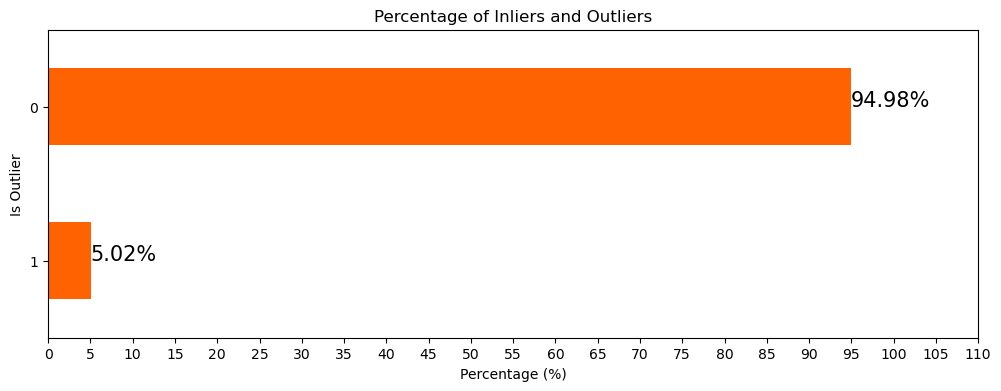

In [31]:
# Calculate the percentage of inliers and outliers
outlier_percentage = rfm['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [32]:
# Separate the outliers for analysis
outliers_data = rfm[rfm['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
rfm_cleaned = rfm[rfm['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
rfm_cleaned = rfm_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
rfm_cleaned.reset_index(drop=True, inplace=True)
rfm_cleaned.shape[0]

4067

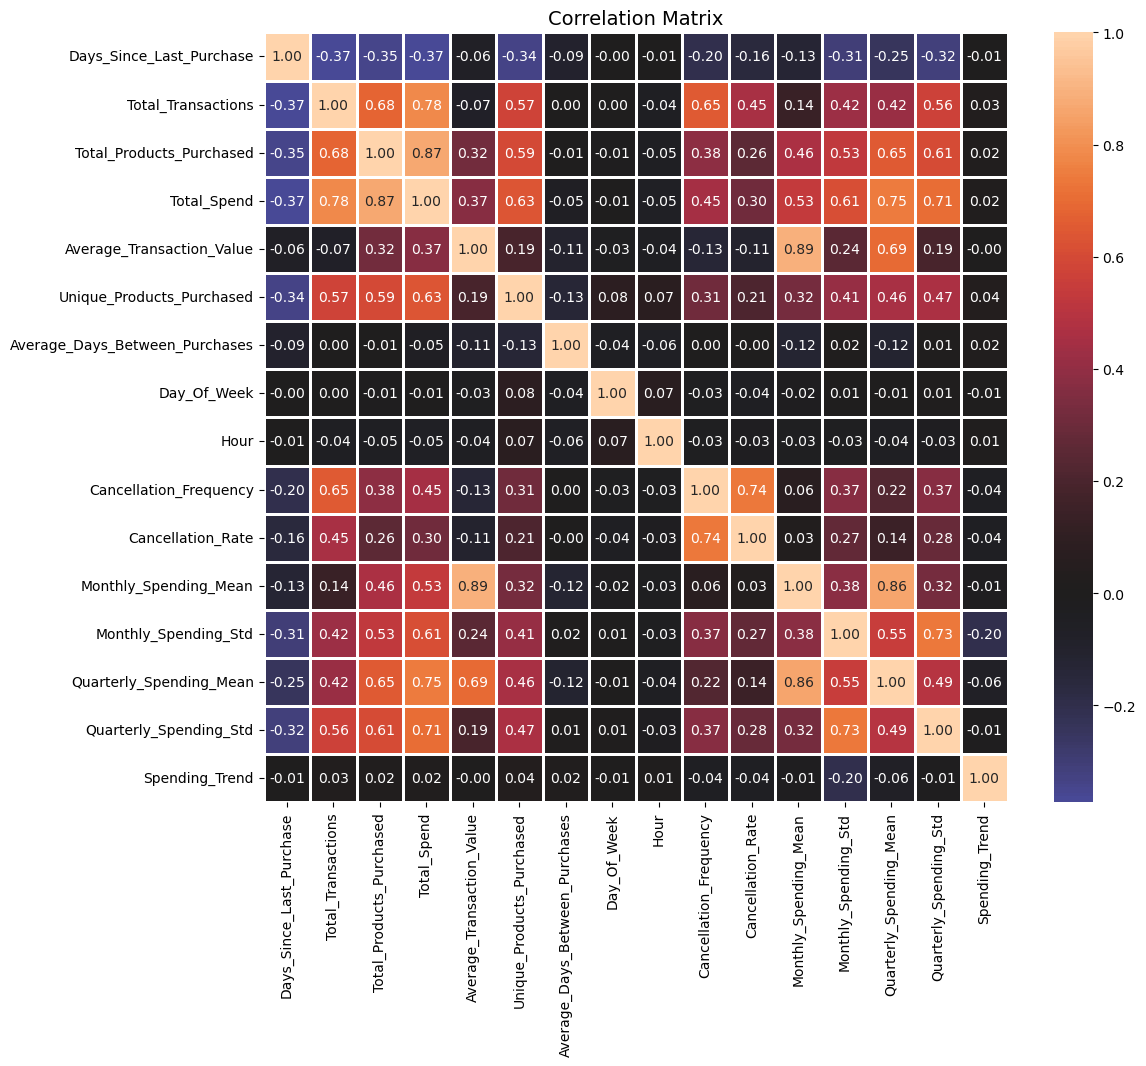

In [33]:
corr = rfm_cleaned.drop(columns=['CustomerID']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

In [34]:
scaler = StandardScaler()
columns_exclude = ['CustomerID', 'Day_Of_Week']
columns_include  = rfm_cleaned.columns.difference(columns_exclude)
rfm_scaled = rfm_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
rfm_scaled[columns_include] = scaler.fit_transform(rfm_scaled[columns_include])

# Display the first few rows of the scaled data
rfm_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Quarterly_Spending_Mean,Quarterly_Spending_Std,Spending_Trend
0,12346.0,2.339058,-0.473603,-0.803433,-0.873874,-1.302364,-0.906736,-0.308669,2,-1.087979,0.380769,0.371070,-1.328128,-0.722040,-1.211163,-0.64155,0.093629
1,12347.0,-0.903561,0.709678,2.213700,2.633046,1.510149,0.804530,-0.125170,2,0.647922,-0.524837,-0.409554,0.998624,1.318500,1.069430,1.20096,0.119709
2,12348.0,-0.170709,-0.000291,2.059038,0.295565,0.338924,-0.571193,0.681780,4,2.817798,-0.524837,-0.409554,0.029686,0.497697,-0.260537,0.25308,-0.492867
3,12349.0,-0.742935,-0.710260,-0.030124,0.312091,5.355560,0.284440,-0.308669,1,-1.521955,-0.524837,-0.409554,4.179877,-0.722040,2.645076,-0.64155,0.093629
4,12350.0,2.188472,-0.710260,-0.562848,-0.634330,0.042422,-0.655079,-0.308669,3,1.515872,-0.524837,-0.409554,-0.215605,-0.722040,-0.432269,-0.64155,0.093629


In [35]:
rfm_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Quarterly_Spending_Mean,Quarterly_Spending_Std,Spending_Trend
0,12346.0,2.339058,-0.473603,-0.803433,-0.873874,-1.302364,-0.906736,-0.308669,2,-1.087979,0.380769,0.371070,-1.328128,-0.722040,-1.211163,-0.64155,0.093629
1,12347.0,-0.903561,0.709678,2.213700,2.633046,1.510149,0.804530,-0.125170,2,0.647922,-0.524837,-0.409554,0.998624,1.318500,1.069430,1.20096,0.119709
2,12348.0,-0.170709,-0.000291,2.059038,0.295565,0.338924,-0.571193,0.681780,4,2.817798,-0.524837,-0.409554,0.029686,0.497697,-0.260537,0.25308,-0.492867
3,12349.0,-0.742935,-0.710260,-0.030124,0.312091,5.355560,0.284440,-0.308669,1,-1.521955,-0.524837,-0.409554,4.179877,-0.722040,2.645076,-0.64155,0.093629
4,12350.0,2.188472,-0.710260,-0.562848,-0.634330,0.042422,-0.655079,-0.308669,3,1.515872,-0.524837,-0.409554,-0.215605,-0.722040,-0.432269,-0.64155,0.093629


# PCA 

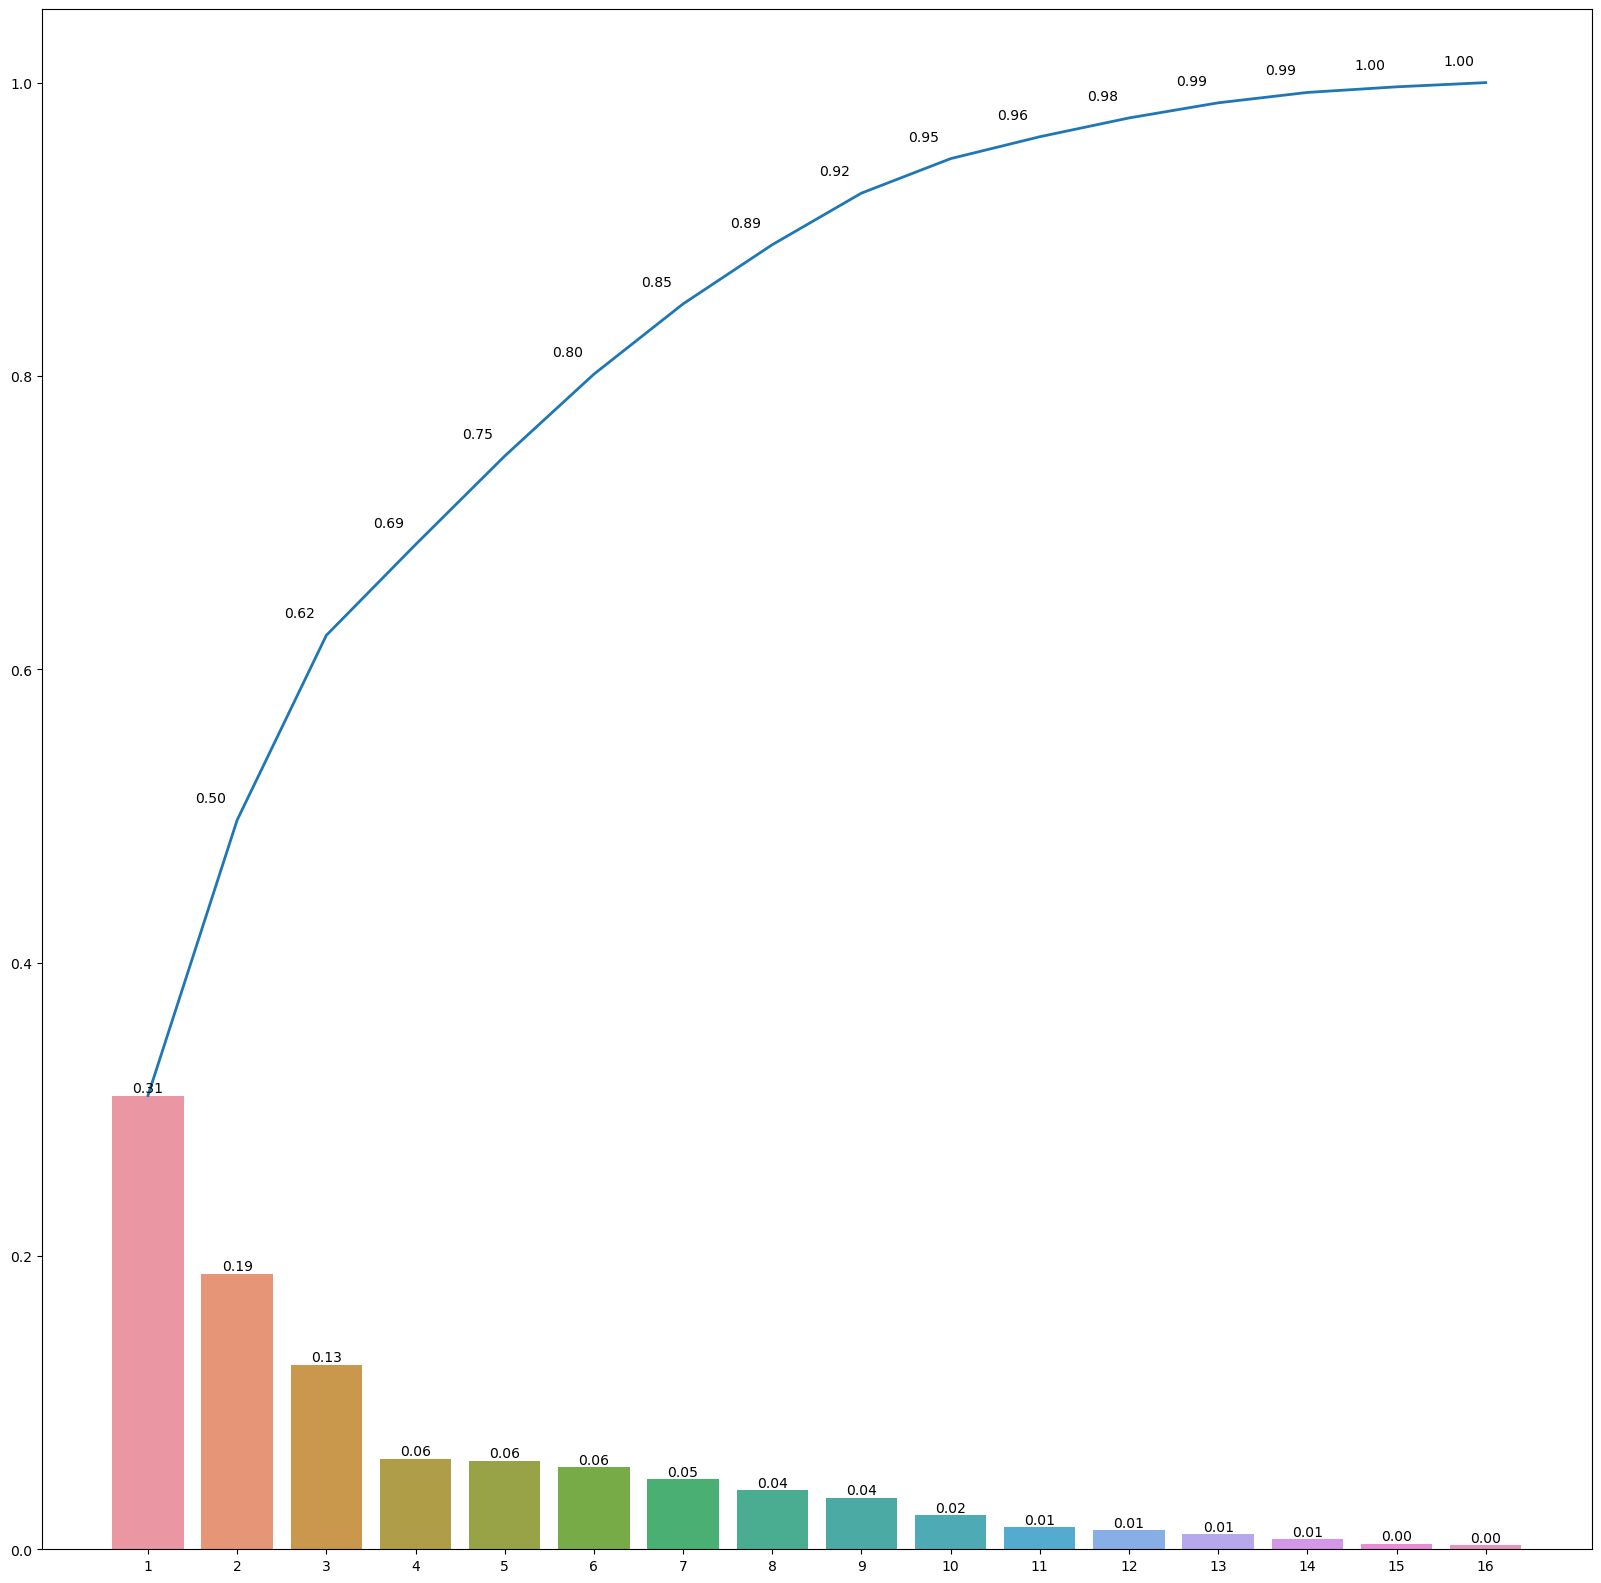

In [37]:
from sklearn.decomposition import PCA
rfm_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
plt.figure(figsize = (20,20))
pca = PCA().fit(rfm_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio)
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,linewidth=2)

plt.xticks(range(0, len(cumulative_explained_variance)))
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
plt.show()

In [38]:
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
rfm_pca = pca.fit_transform(rfm_scaled)
rfm_pca = pd.DataFrame(rfm_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
rfm_pca.index = rfm_scaled.index
rfm_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.723175,-1.634937,1.391512,1.079282,-0.632289,-1.271820
12347.0,3.943851,-1.474846,-1.438236,-1.140606,0.252583,0.968668
12348.0,0.678890,0.565331,-0.340138,-0.748584,0.069554,2.334842
12349.0,2.503585,-2.798238,-6.111248,0.688337,-0.130055,-2.039574
12350.0,-2.109504,-0.492231,-0.734412,0.271264,-1.380274,0.561808


In [39]:
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=rfm_scaled.columns)
pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.187223,-0.006926,-0.111134,0.302335,-0.272362,-0.217218
Total_Transactions,0.316823,0.006638,0.305915,-0.122599,-0.062949,-0.048256
Total_Products_Purchased,0.357786,-0.002623,0.006262,-0.155568,0.027085,-0.019995
Total_Spend,0.392061,-0.000165,0.004052,-0.109479,-0.001706,-0.029378
Average_Transaction_Value,0.183158,-0.024292,-0.530411,0.084184,-0.026500,-0.122223
Unique_Products_Purchased,0.290098,0.056774,0.046419,-0.241216,-0.166237,0.153395
Average_Days_Between_Purchases,-0.026061,-0.032767,0.115309,-0.173869,0.717210,-0.075591
Day_Of_Week,-0.002435,0.995058,-0.005533,0.038798,0.038764,-0.071929
Hour,-0.018499,0.056590,0.008317,-0.197665,-0.387724,0.698545
Cancellation_Frequency,0.228911,-0.021688,0.397021,0.256853,-0.180439,-0.191733


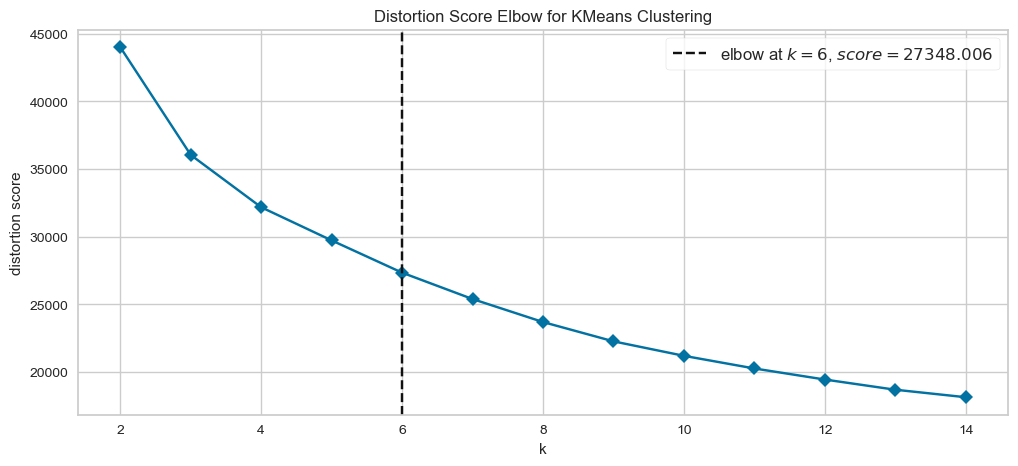

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
from yellowbrick.cluster import KElbowVisualizer
km = KMeans(init='k-means++', n_init=10, max_iter=300, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(rfm_pca)

# Finalize and render the figure
visualizer.show()

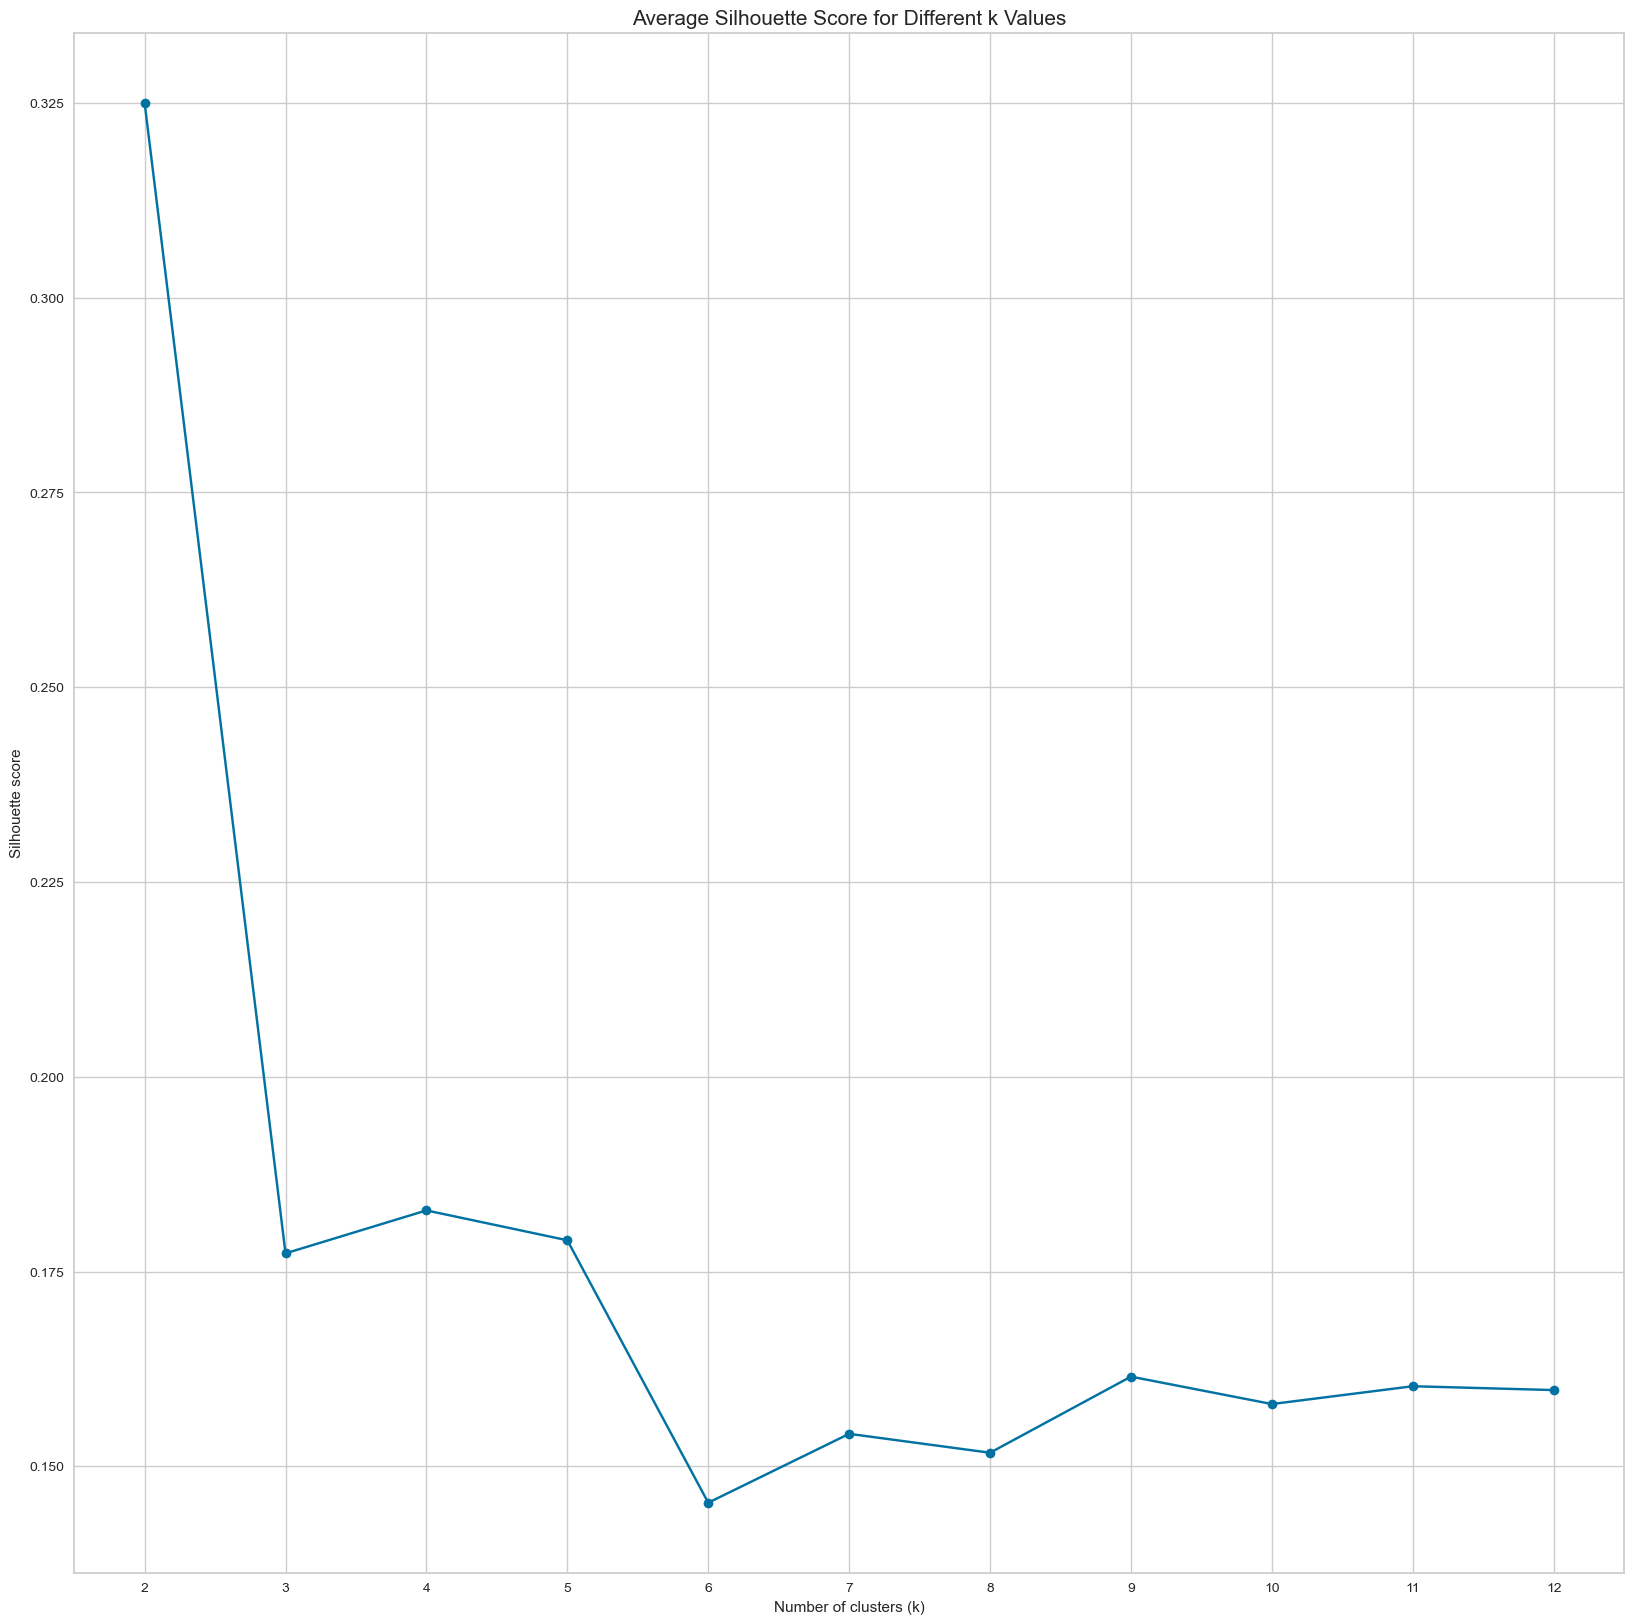

2

In [45]:
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

def silhouette_analysis(df,k_start,k_end):
    plt.figure(figsize = (20,20))
    silhouette_scores = []
    for k in range(k_start, k_end + 1):
        km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=666)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)
        
    best_k = k_start + silhouette_scores.index(max(silhouette_scores))
    plt.plot(range(k_start, k_end + 1), silhouette_scores, marker='o')
    plt.xticks(range(k_start, k_end + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)
    
    for i in range(k_start,k_end+1):    
        km = KMeans(n_clusters=i,  n_init=10, max_iter=300, random_state=666)
        #row_idx, col_idx = divmod(i - k_start, 2)

        # Assign the plots to the second, third, and fourth rows
        #ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)
    
    
    
    plt.show()
    return best_k
silhouette_analysis(rfm_scaled,2,12)

In [47]:
from collections import Counter
kmeans = KMeans(n_clusters=4, n_init=10, max_iter=300, random_state=666)
kmeans.fit(rfm_pca)
cluster_frequencies = Counter(kmeans.labels_)
cluster_frequencies

Counter({2: 1553, 0: 546, 1: 1532, 3: 436})

In [48]:
rfm_pca['cluster'] = kmeans.labels_
rfm_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,cluster
CustomerID,,,,,,,
12346.0,-2.723175,-1.634937,1.391512,1.079282,-0.632289,-1.271820,2
12347.0,3.943851,-1.474846,-1.438236,-1.140606,0.252583,0.968668,0
12348.0,0.678890,0.565331,-0.340138,-0.748584,0.069554,2.334842,1
12349.0,2.503585,-2.798238,-6.111248,0.688337,-0.130055,-2.039574,0
12350.0,-2.109504,-0.492231,-0.734412,0.271264,-1.380274,0.561808,2


In [51]:
from sklearn.metrics import calinski_harabasz_score
from tabulate import tabulate
n_observations = len(rfm_pca)
X = rfm_pca.drop('cluster', axis=1)
clusters = rfm_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)

table_data = [
    ["Number of Observations", n_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score]]

print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        4067         |
|    Silhouette Score     | 0.23600318009689125 |
| Calinski Harabasz Score | 1174.4671820818512  |
+-------------------------+---------------------+


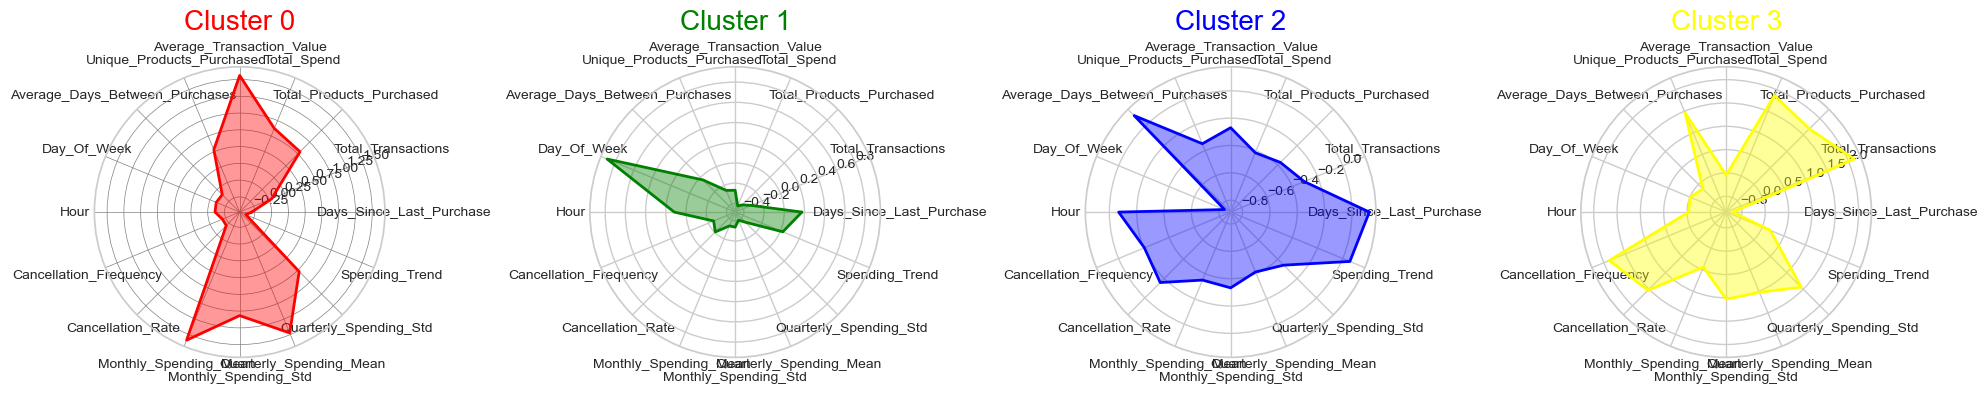

In [52]:
rfm_cleaned['cluster'] = kmeans.labels_
df_rfm = rfm_cleaned.set_index('CustomerID')
scaler = StandardScaler()
df_rfm_standardized = scaler.fit_transform(df_rfm.drop(columns=['cluster'], axis=1))
df_rfm_standardized = pd.DataFrame(df_rfm_standardized, columns=df_rfm.columns[:-1], index=df_rfm.index)
df_rfm_standardized['cluster'] = df_rfm['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_rfm_standardized.groupby('cluster').mean()

def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)
    
# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(1,4,figsize=(20, 20), subplot_kw=dict(polar=True))

colors = ['red', 'green', 'blue', 'yellow']
# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

ax[3].set_xticks(angles[:-1])
ax[3].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()